In [119]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from tqdm import tqdm
from utils import plot_3d_trajectory, plot_observations
from utils import solve_lorenz
from utils import evaluate
import numpy as np
from scipy.integrate._ivp.rk import RK23, RK45, DOP853
from utils import plot_estim_evolution
from utils import sgd_update
import torch
import torch.nn as nn

In [120]:
import configparser

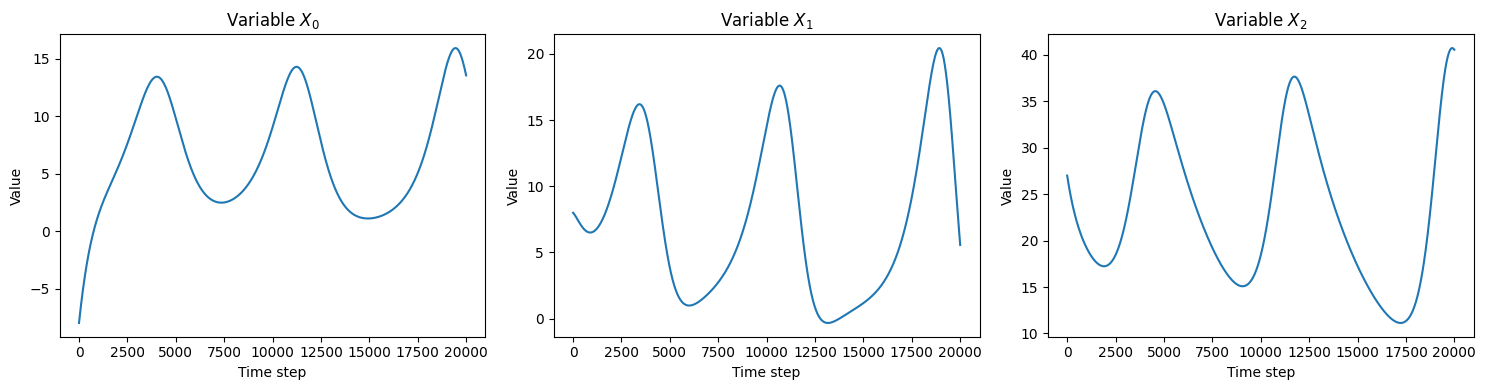

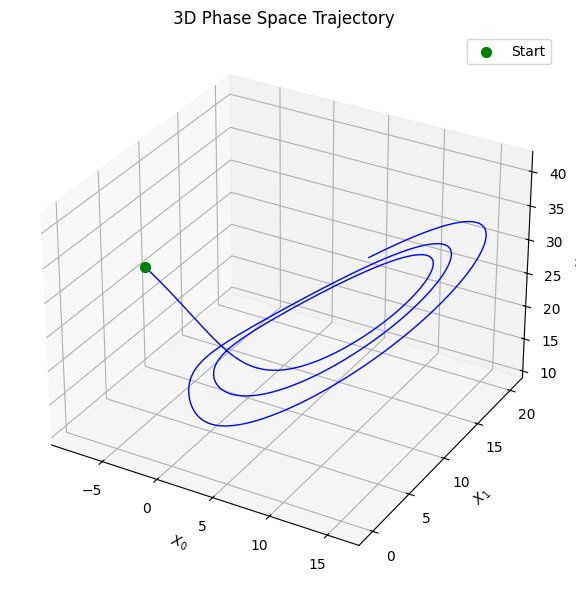

In [121]:
def f(X, theta):
    return np.array([theta[0]*X[1] - theta[0]*X[0],
                     theta[1]*X[0] - X[0]*X[2] - X[1],
                     X[0]*X[1] - theta[2]*X[2]])

def runge_kutta4(f, X_n, theta, h):
    k1 = f(X_n, theta)
    k2 = f(X_n + h*k1/2, theta)
    k3 = f(X_n + h*k2/2, theta)
    k4 = f(X_n + h*k3, theta)
    return X_n + h*(k1 + 2*k2 + 2*k3 + k4)/6

X_0 = np.array([-8.0, 8.0, 27.0], dtype=np.float64)
theta = np.array([10.0, 28.0, 8.0/3.0], dtype=np.float64)

t_0, t_f = 0, 2
h = 1e-4
N = int((t_f-t_0)/h)

observations = np.zeros((N, 3))
observations[0] = np.array(X_0)

for n in range(N-1):
    observations[n+1] = runge_kutta4(f, observations[n], theta, h)

observations_solver = solve_lorenz(t_0=t_0, t_f=t_f, dt=h, X_0=X_0)
plot_observations(observations)
plot_3d_trajectory(observations)

In [122]:
def compute_grad(f, methode, theta_estim, A, estim_obs, n):
    sum_term = np.dot(estim_obs[:n], A).sum(axis=0)   

    X_nm1 = estim_obs[n-1]
    X_n   = estim_obs[n] 
    
    error = methode(f, X_nm1, theta_estim, h) -  X_n
    # error = h * f(X_nm1, theta_estim) + X_nm1 -  X_n

    grad = sum_term * error
    return grad


In [123]:
theta_estim = np.array([-5.0, -3.0, 10.0])

config = configparser.ConfigParser()
config.read('config.ini')

A = np.array([[-1, 1, 0],
              [1 , 0, 0],
              [0 , 0, -1]])

estim_obs = observations.copy()

theta_estim_vec = np.zeros((N, 3))
theta_estim_vec[0] = theta_estim


for n in tqdm(range(1, N)):
    grad = compute_grad(f, runge_kutta4, theta_estim, A, estim_obs, n)
    theta_estim = sgd_update(theta_estim, config, grad)
    theta_estim_vec[n] = theta_estim

  0%|          | 0/19999 [00:00<?, ?it/s]

100%|██████████| 19999/19999 [00:28<00:00, 705.98it/s]


L'erreur relative sur σ, ρ, β est de : 2.5221001571651414e-05, 3.015441864460757e-09, 5.204969788508151e-09


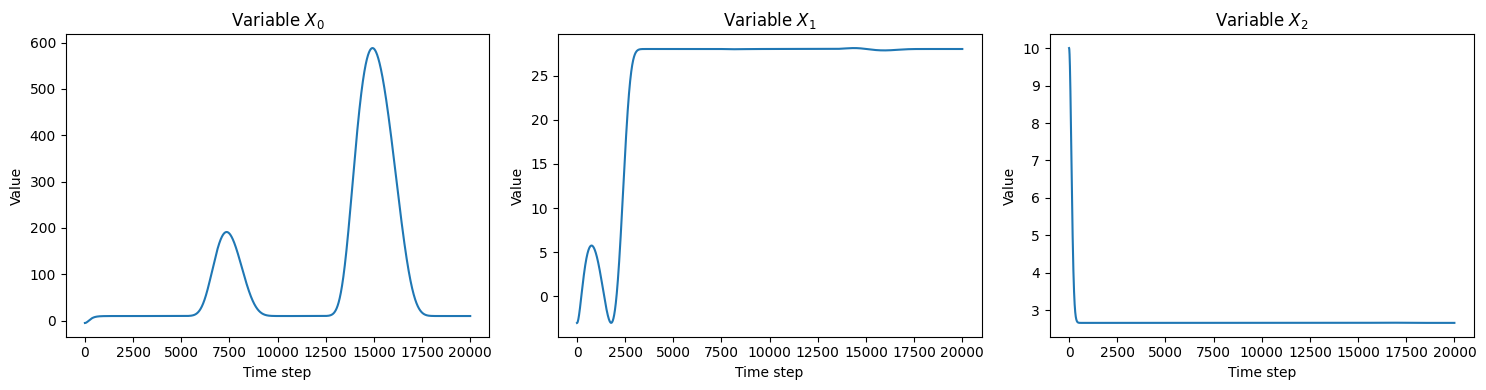

In [124]:
evaluate(theta_estim, theta)

plot_estim_evolution(theta_estim_vec)

In [125]:
theta_estim = np.array([-5.0, -3.0, 10.0])

config = configparser.ConfigParser()
config.read('config.ini')

A = np.array([[-1, 1, 0],
              [1 , 0, 0],
              [0 , 0, -1]])

estim_obs = observations.copy()

theta_estim_vec = np.zeros((N, 3))
theta_estim_vec[0] = theta_estim
batch_size = 16

num_batches = N // batch_size

for batch_idx in tqdm(range(num_batches)):

    grad = np.zeros_like(theta_estim)

    start = batch_idx * batch_size
    end = start + batch_size

    for idx in range(start, end):
        grad += compute_grad(
            f, runge_kutta4, theta_estim, A, estim_obs, idx
        )

    grad /= batch_size
    theta_estim = sgd_update(theta_estim, config, grad)

    theta_estim_vec[batch_idx] = theta_estim


  0%|          | 0/1250 [00:00<?, ?it/s]

100%|██████████| 1250/1250 [00:26<00:00, 47.75it/s]


L'erreur relative sur σ, ρ, β est de : 33.90196009877927, 0.0035833178811728317, 0.006921757196726164


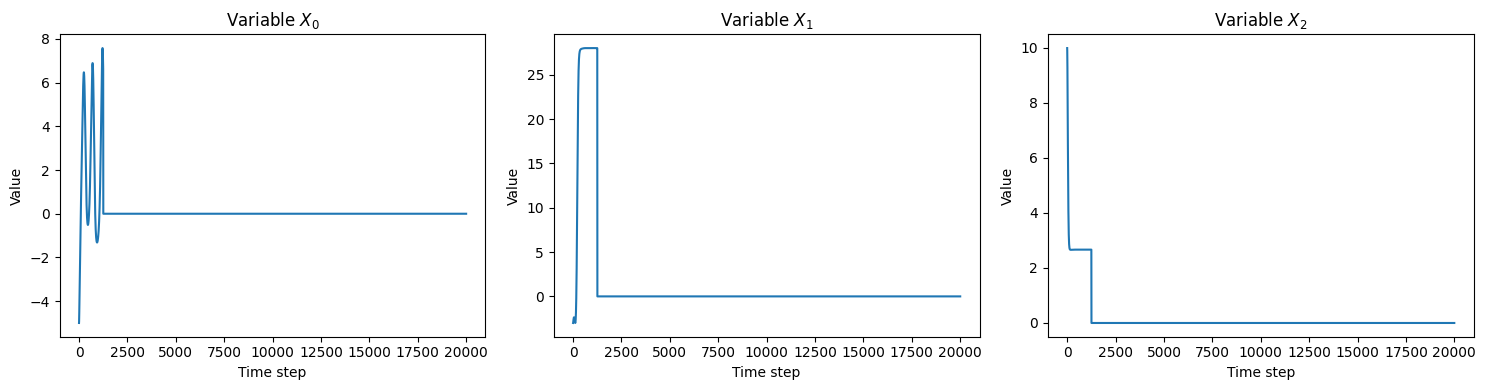

In [126]:
evaluate(theta_estim, theta)

plot_estim_evolution(theta_estim_vec)

In [ ]:
# sigma.grad = torch.tensor([1.0, 1.0])

In [127]:
# https://github.com/scipy/scipy/blob/b2b7944064af15bd87e781216c2dfda7400ecd2d/scipy/integrate/_ivp/rk.py

In [128]:
# import numpy as np
# from scipy.integrate._ivp.rk import RK45

# # Initial condition
# X_0 = np.array([-8.0, 8.0, 27.0], dtype=np.float64)

# # Initial and final time
# t0 = 0.0
# t_bound = 10.0

# # Number of stored observations
# N = 50_000
# observations = np.zeros((N, 3))
# observations[0] = X_0

# # Create solver
# solver = RK45(lorenz, t0, X_0, t_bound,
#               rtol=1e-7, atol=1e-9,
#               max_step=np.inf)


# n = 0
# while solver.status == "running":
#     solver.step()
#     n += 1
#     observations[n] = solver.y
